# <center> CLOTHES GENERATION FROM MNIST FROM DC-GAN</center>

Inspired by: [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan) tutorial.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import platform
import imageio
import PIL
import time
import os
import glob
import zipfile
from IPython import display

In [2]:
tf.executing_eagerly()

True

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [4]:
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (60000, 28, 28)
y_train.shape:  (60000,)
x_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [5]:
x_train = np.concatenate((x_train, x_test), axis=0)
print('x_train.shape: ', x_train.shape)

x_train.shape:  (70000, 28, 28)


In [6]:
TOTAL_EXAMPLES_NUM = x_train.shape[0]

print('TOTAL_EXAMPLES_NUM: ', TOTAL_EXAMPLES_NUM)

TOTAL_EXAMPLES_NUM:  70000


In [7]:
print('y_train[0] =', y_train[0])

y_train[0] = 9


In [8]:
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

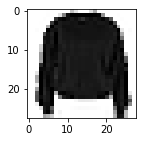

In [9]:
plt.figure(figsize=(2, 2))
plt.imshow(x_train[7], cmap=plt.cm.binary)
plt.show()

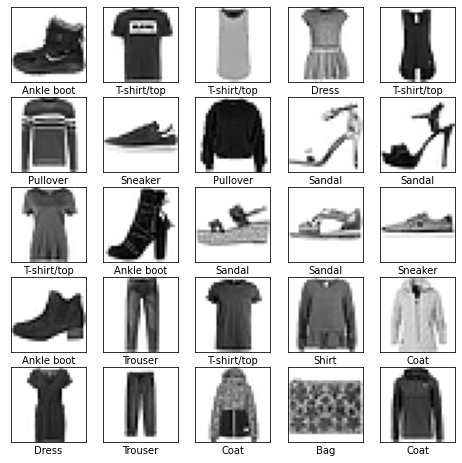

In [10]:
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(8, 8))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Reshaping and Normalizing 

In [11]:
x_train_reshaped = x_train.reshape(
    x_train.shape[0],
    x_train.shape[1],
    x_train.shape[2],
    1
).astype('float32')

In [12]:
print('x_train_reshaped.shape: ', x_train_reshaped.shape)

x_train_reshaped.shape:  (70000, 28, 28, 1)


In [13]:
x_train_normalized = (x_train_reshaped - 127.5) / 127.5

In [14]:
print('Normalized data values:\n')
print(x_train_normalized[0,:,:,0])

Normalized data values:

[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1. 

## Creating a batched dataset

In [15]:
SHUFFLE_BUFFER_SIZE = TOTAL_EXAMPLES_NUM
BATCH_SIZE = 1024

TRAINING_STEPS_PER_EPOCH = math.ceil(TOTAL_EXAMPLES_NUM / BATCH_SIZE)

print('BATCH_SIZE: ', BATCH_SIZE)
print('TRAINING_STEPS_PER_EPOCH: ', TRAINING_STEPS_PER_EPOCH)

BATCH_SIZE:  1024
TRAINING_STEPS_PER_EPOCH:  69


In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_normalized) \
    .shuffle(SHUFFLE_BUFFER_SIZE) \
    .batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>


---
## NETWORKS

### Generator

In [17]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(
        units=7*7*256,
        use_bias=False,
        input_shape=(100,)
    ))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=128,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        use_bias=False
    ))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=64,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        use_bias=False
    ))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=1,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        use_bias=False,
        activation='tanh'
    ))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [18]:
generator_model = make_generator_model()

In [19]:
generator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [20]:
noise = tf.random.normal(shape=[1, 100])
print(noise.numpy())

[[-0.7144395   1.1446317  -0.9062035   0.11704226  1.6023549   0.36949036
   2.3579514   0.10351267  2.6276734   0.71769965 -0.9276659   0.5136459
   0.22351626  0.20178942  0.49201697  1.1111405  -1.5312703  -0.47806868
   0.15914217 -0.8184133   0.95871997  0.16126826  0.16710457  1.0165015
   0.27935916 -1.841452    0.494956   -0.09199325  0.12084107  0.312675
   0.33135208  0.7061303  -0.06220317 -0.16012338 -0.43832403 -0.18978755
  -0.07594673 -0.10637226  0.18872751 -2.3918366  -0.36663118 -0.4897189
  -0.0711771  -1.8316776  -0.3620086  -0.4645394   0.4053284   0.31649235
  -1.4407839  -1.2391707  -0.5707179   0.40273955 -0.9082198  -1.4688014
  -2.0869355  -0.37712902  0.25646132 -1.0546141  -1.713378    1.5046762
  -0.14994426 -0.22535224  0.12026349  0.90584475  0.8425626   0.09476872
  -0.8275675  -0.33924043 -0.2061166  -1.3940427   0.18007526 -1.0612997
  -1.0101529   1.0648884  -0.08022347 -1.115824    0.2360816   0.6385971
   1.6515992   0.52946824  0.1771636  -0.914698

In [21]:
generated_image = generator_model(noise, training=False)

print('generated_image.shape: ', generated_image.shape)

generated_image.shape:  (1, 28, 28, 1)


In [22]:
print(generated_image[0, :, :, 0].numpy())

[[-2.57884315e-03 -1.44405058e-03 -1.58411101e-03 -6.82590762e-03
   2.56541208e-03 -7.23885233e-03  5.71902608e-03  9.92994639e-04
  -2.53891945e-03  2.27835786e-04 -3.26384790e-04 -4.98634111e-03
   4.56496282e-03 -7.44792400e-03  1.11409870e-03 -1.27433741e-03
   3.54748708e-03 -2.90362095e-03 -6.03126176e-03 -8.13437440e-03
   4.88240598e-03 -5.43472730e-03 -1.93252985e-03 -2.33787927e-03
   2.66668946e-03 -7.47507904e-04  9.38622921e-04  6.17412012e-03]
 [-4.30702930e-04  5.93477581e-03  2.78624892e-03 -2.61322572e-03
   4.10067057e-03  2.70403153e-03  5.32083213e-04 -1.41924322e-02
   4.16355068e-03 -4.45000688e-03 -1.17940865e-02  1.55205019e-02
  -1.91867165e-03 -4.32076957e-03  2.48177996e-04  3.85342422e-03
   2.15786975e-03 -2.06516273e-02  7.13116780e-04  8.88178311e-03
   2.89796013e-03 -1.94036048e-02 -6.36653416e-03 -6.18528994e-03
   1.26900300e-02 -7.03881029e-03 -6.99865399e-03  4.07633698e-03]
 [-2.41358276e-03 -4.22377372e-03 -1.95888663e-03 -1.66419651e-02
   3.777

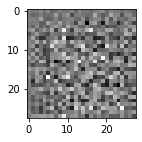

In [23]:
plt.figure(figsize=(2, 2))
plt.imshow(generated_image[0, :, :, 0], cmap=plt.cm.binary)

### Discriminator

In [24]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        input_shape=[28, 28, 1]
    ))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same'
    ))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [25]:
discriminator_model = make_discriminator_model()

In [26]:
discriminator_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [27]:
decision = discriminator_model(generated_image)

print(decision)

tf.Tensor([[-0.0002265]], shape=(1, 1), dtype=float32)


---
## Losses & Opimizers 

### Discriminator Loss

In [28]:
def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    
    total_loss = real_loss + fake_loss
    
    return total_loss

In [29]:
output_combinations = [
     # REAL  #FAKE
    ([-1.],  [1.]),
    ([1.],   [-1.]),  
    ([1.],   [0.]),
    ([10.],  [-1.]),                       
]
for (real_output, fake_output) in output_combinations:
    loss = discriminator_loss(real_output, fake_output).numpy()
    print('Discriminator loss for:', real_output, fake_output)
    print('REAL output:', real_output)
    print('FAKE output:', fake_output)
    print('loss: ', loss)
    print()

Discriminator loss for: [-1.0] [1.0]
REAL output: [-1.0]
FAKE output: [1.0]
loss:  2.6265235

Discriminator loss for: [1.0] [-1.0]
REAL output: [1.0]
FAKE output: [-1.0]
loss:  0.62652344

Discriminator loss for: [1.0] [0.0]
REAL output: [1.0]
FAKE output: [0.0]
loss:  1.0064089

Discriminator loss for: [10.0] [-1.0]
REAL output: [10.0]
FAKE output: [-1.0]
loss:  0.3133071



### Generator Loss

In [30]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [31]:
print('Generator loss for >1: ', generator_loss([5.]).numpy())
print('Generator loss for =0: ', generator_loss([0.]).numpy())

Generator loss for >1:  0.0067153485
Generator loss for =0:  0.6931472


### Optimizers 

In [32]:
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

### Checkpoints

In [33]:
checkpoint_dir = './tmp/ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator_model=generator_model,
    discriminator_model=discriminator_model
)

## TRAINING

In [34]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
input_noise_seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [35]:
def train_step(real_images):
    training_history = {
        'discriminator': {
            'loss': None
        },
        'generator': {
            'loss': None
        }
    }

    noise_images = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model(
            noise_images,
            training=True
        )
        
        real_output = discriminator_model(
            real_images,
            training=True
        )
        fake_output = discriminator_model(
            generated_images,
            training=True
        )
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(
            real_output,
            fake_output
        )

        training_history['discriminator']['loss'] = disc_loss.numpy()
        training_history['generator']['loss'] = gen_loss.numpy()
    
    gradients_of_generator = gen_tape.gradient(
        gen_loss,
        generator_model.trainable_variables
    )
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss,
        discriminator_model.trainable_variables
    )
    
    generator_optimizer.apply_gradients(zip(
        gradients_of_generator,
        generator_model.trainable_variables
    ))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator_model.trainable_variables
    ))

    return training_history

In [36]:
def train(dataset, epochs, start_epoch=0):
    print('Start training...')
    
    training_history = {
        'discriminator': {
            'loss': []
        },
        'generator': {
            'loss': []
        }
    }

    for epoch in range(epochs)[start_epoch:]:
        print('Start epoch #{} ({} steps)...'.format(epoch + 1, TRAINING_STEPS_PER_EPOCH))
        
        start = time.time()
        
        step = 0
        for image_batch in dataset:
            step += 1
            '''
             display.clear_output(wait=True)
             show_progress(step, TRAINING_STEPS_PER_EPOCH)
             generate_and_save_images(
                 generator_model,
                 epoch + 1,
                 input_noise_seed,
                 save=False
             ) '''
            
            training_step_history = train_step(image_batch)

            discriminator_step_loss = training_step_history['discriminator']['loss']
            generator_step_loss = training_step_history['generator']['loss']

        training_history['discriminator']['loss'].append(discriminator_step_loss)
        training_history['generator']['loss'].append(generator_step_loss)
            
        # Producing the images for the GIF in the end.
        display.clear_output(wait=True)
        generate_and_save_images(
            generator_model,
            epoch + 1,
            input_noise_seed
        )
        
        # Saving the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print('Time for epoch #{} is {:.2f}s'.format(epoch + 1, time.time() - start))
        print('Discriminator loss: {:.4f}'.format(discriminator_step_loss))
        print('Generator loss: {:.4f}'.format(generator_step_loss))

    return training_history

In [37]:
def show_progress(current_step, total_steps):
    length_divider = 2
    progress = math.floor(current_step * 100 / total_steps)
    done_steps = progress
    left_steps = 100 - done_steps
    done_dots = ''.join(['◼︎' for step in range(math.floor(done_steps / length_divider))])
    left_dors = ''.join(['・' for step in range(math.floor(left_steps / length_divider))])
    print(f'{current_step}/{total_steps}: {done_dots}{left_dors}')

In [38]:
IMAGES_PREVIEW_PATH = 'tmp/imgs/'

if not os.path.exists(IMAGES_PREVIEW_PATH):
    os.makedirs(IMAGES_PREVIEW_PATH)

In [39]:
def generate_and_save_images(model, epoch, test_input, save=True):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig_dimension = int(math.sqrt(num_examples_to_generate))
    plt.figure(figsize=(8, 8))
    fig = plt.figure(figsize=(fig_dimension, fig_dimension))
    
    for i in range(predictions.shape[0]):
        plt.subplot(fig_dimension, fig_dimension, i+1)
        plt.imshow(
            predictions[i, :, :, 0] * 127.5 + 127.5,
            cmap=plt.cm.binary
        )
        plt.axis('off')
        
    if save:
        plt.savefig('{}image_at_epoch_{:04d}.png'.format(IMAGES_PREVIEW_PATH, epoch))
        
    plt.show()

In [40]:
if not 'training_history' in locals():
    training_history = {
        'discriminator': {
            'loss': []
        },
        'generator': {
            'loss': []
        }
    }

In [41]:
training_session_num = 1
start_epoch = training_session_num * EPOCHS
epochs_num = start_epoch + EPOCHS

<Figure size 576x576 with 0 Axes>

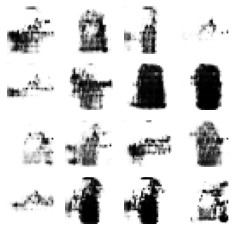

Time for epoch #200 is 19.53s
Discriminator loss: 0.7036
Generator loss: 1.8267


In [42]:
training_history_current = train(
    train_dataset,
    epochs=epochs_num,
    start_epoch=start_epoch
)

### Analysing Training History

In [43]:
training_history['generator']['loss'] += training_history_current['generator']['loss']
training_history['discriminator']['loss'] += training_history_current['discriminator']['loss']

In [44]:
def render_training_history(training_history):
    generator_loss = training_history['generator']['loss']
    discriminator_loss = training_history['discriminator']['loss']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(generator_loss, label='Generator loss')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(discriminator_loss, label='Discriminator loss')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

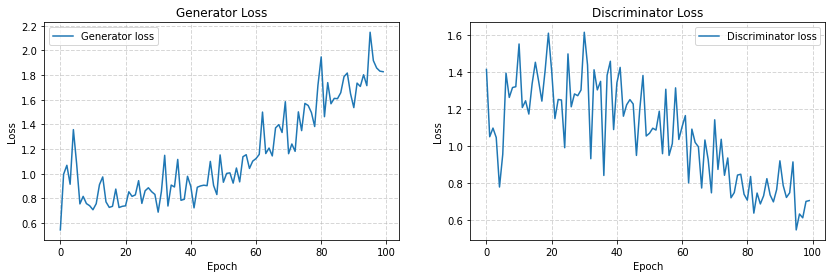

In [45]:
render_training_history(training_history)

In [46]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## SAVE MODELS

In [47]:
generator_model.save('generator_model.h5', save_format='h5')
discriminator_model.save('discriminator_model.h5', save_format='h5')

### ZIP IMAGES

In [48]:
def zip_image_previews():
    images_previews_path = IMAGES_PREVIEW_PATH
    images_previews_zip_name = 'images_previews.zip'

    zipped_files_num = 0
    with zipfile.ZipFile(images_previews_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(images_previews_path):
            for filename in filenames:
                zipped_files_num += 1
                file_path = os.path.join(folder_name, filename)
                zip_obj.write(file_path, os.path.basename(file_path))
    print('Zipped {} files to '.format(zipped_files_num), images_previews_zip_name)

In [49]:
zip_image_previews()

Zipped 100 files to  images_previews.zip


### TEST MODELS

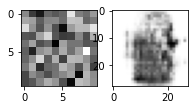

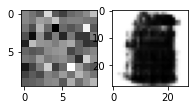

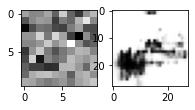

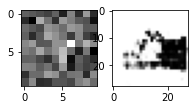

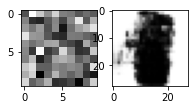

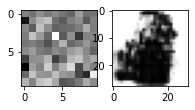

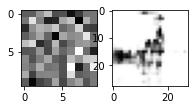

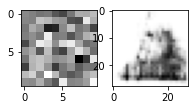

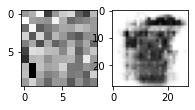

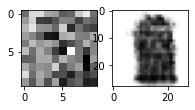

In [50]:
test_examples_num = 10

noise_images = tf.random.normal([test_examples_num, 100])
generated_images = generator_model(noise_images, training=False)

for example_num in range(test_examples_num):
    plt.figure(figsize=(3, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(noise_images[example_num], (10, 10)), cmap=plt.cm.binary)

    plt.subplot(1, 2, 2)
    plt.imshow(generated_images[example_num, :, :, 0], cmap=plt.cm.binary)

## Creating a GIF

In [55]:
def display_image(epoch_no):
    return PIL.Image.open('{}image_at_epoch_{:04d}.png'.format(IMAGES_PREVIEW_PATH, epoch_no+1))

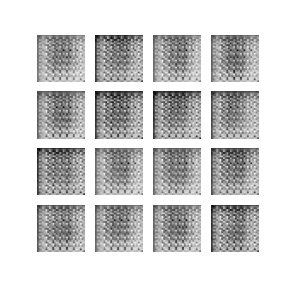

In [56]:
display_image(EPOCHS)

In [57]:
anim_file = 'clothes_generation_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(IMAGES_PREVIEW_PATH + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

display.Image(filename=anim_file)

ValueError: ignored